# Network analysis in Senegal

### Objectives
    1)	Use measures of road-based accessibility to identify road segments that, if rehabilitated, would improve agricultural market activities in Senegal, including during flood conditions.
    2)	Gain a better understanding of the accessibility, connectivity, and criticality of roads in Senegal in relationship to agricultural origins, processing & transfer sites, and markets.

To this end, the team will develop an accessibility model which measures the travel time from sites of agricultural production to their nearest populated areas, processing centers, and markets. 

### Datasets for analysis
#### ORIGIN
    1) agriculture: MapSPAM 2017. Measuring value in international dollars.
    2) agriculture: UMD Land Cover 2019 30m. Assign MapSPAM value onto land cover cropland class for more precise origin information.
    3) population: WorldPop 2020, UN-adjusted.
    4) settlement extent: GRID3 2020.
#### DESTINATION
    4) markets: derived from WorldPop 2020 and GRID3 2020 urban clusters.
    5) agricultural processing hubs: to be acquired.
#### TRAVEL ROUTE
    6) roads: OpenStreetMap, July 2021.
    7) elevation: 
#### OBSTACLE
    8) flood: FATHOM. 1-in-10, 20, and 50 year flood return periods. These are combined pluvial and fluvial (undefended) flood layers whereby whichever flood level was higher was retained.
#### INTERVENTION
    9) upcoming road projects: AGEROUTE interventions separate from the World Bank-financed project
    10) targeted road projects: critical road segments identified by this accessibility model's baseline outputs


### Model design
#### Basic formula: 
    (a) Off-road driving time from origin to closest road node
    +
    (b) Driving time from road node in (a) to a destination (closeness measured by road segments speeds)

#### Model origin & destination (OD) sets:
    A)	Travel time from an area that has agricultural value/potential to the nearest processing hub (if provided).
    B)	Travel time from an area that has agricultural value/potential to the nearest larger settlement, (“larger” settlement identified using a case-appropriate population metric to be determined).
    C)	Travel time from an area that has agricultural value/potential to the nearest market.
    D)	Travel time from all settlements to the nearest market.
    E)	Travel time from larger settlements to the nearest market.

#### Before/after scenarios for each OD set:
    1)	Pre-project, baseline weather: No inclement weather. Road network status as of November 2021.
    2)	Pre-project, flood: 1-in-10, 1-in-20 and 1-in-50 year flood return period. Road network status as of November 2021.
    3)	Post-project, baseline weather: No inclement weather. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).
    4)	Post-project, flood: 1-in-10 year flood return period. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).

#### Notes:
    --Destinations are expected to be proximal to the road network, so no measure is taken between road and destination.
    --All travel times will be assigned to each model variation’s point of origin; the aggregation up to admin areas is possible if desired.
    --Obstacles & interventions modify the road segment speeds. Basic formula is then applied to the modified road network.


### Prep workspace

In [1]:
import os, sys
GISFolder = os.getcwd()
GISFolder

'C:\\Users\\wb527163\\GEO-Cdrive-Grace'

In [2]:
# Note: needed to reinstall rtree due to geopandas import error. Did so in the console. 
# conda install -c conda-forge rtree=0.9.3

In [3]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
sys.path.append(r"C:\Users\wb527163\.conda\envs\geo\GOSTnets-master")
import GOSTnets as gn

In [4]:
import networkx as nx
import osmnx as ox
import numpy as np
import rasterio as rt
import shapely
from shapely.geometry import Point, box, Polygon
from shapely.ops import unary_union, linemerge, transform
from shapely.wkt import loads
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point
import peartree

In [5]:
#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob

In [6]:
from GOSTnets import load_osm as losm
import importlib

In [7]:
pth = os.path.join(GISFolder, "SEN-Cdrive") # Personal folder system for running model.
pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive'

In [8]:
out_pth = os.path.join(GISFolder, "SEN-Cdrive\outputs") # For storing intermediate outputs from the model.
out_pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive\\outputs'

In [9]:
team_pth = 'R:\\SEN\\GEO' # This is where the unmodified input data is stored. Finalized outputs also housed here.
team_pth

'R:\\SEN\\GEO'

### Prepare OSM driving network.
Travel measured in length (meters).

In [10]:
# Earlier, created an approximate bounding area which includes parts of neighboring countries and all of The Gambia.
aoi = gpd.read_file("R:/SEN/GEO/Roads/bounding_senegam_buffered.shp") # AOI = Area of Interest
print(aoi)

   id       bound                                           geometry
0   0  senegambia  POLYGON ((-16.79591 16.13764, -16.44946 16.908...


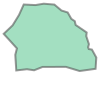

In [11]:
bound = aoi.geometry.iloc[0]
bound # Check that it's shaped like Senegal & Gambia.

In [12]:
aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
gDrive = ox.graph_from_polygon(bound, network_type= 'drive', simplify=False, clean_periphery=False)
# Note: length is measured in meters.
# Took approximately 30 min.

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [14]:
node_drive = gn.node_gdf_from_graph(gDrive)
node_drive.to_csv(os.path.join(out_pth, 'node_drive_unclean.csv'))

In [15]:
gn.example_edge(gDrive, 2)

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832})


#### Convert the graph to time, then save to file. Edges contain the time measure.

In [17]:
G_edges_drive = gn.edge_gdf_from_graph(gDrive)

In [18]:
G_nodes_drive = gn.node_gdf_from_graph(gDrive)

In [19]:
print(G_edges_drive.info()) # 4,012,565
print(G_nodes_drive.info()) # 1,829,568

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4012565 entries, 0 to 4012564
Data columns (total 17 columns):
 #   Column    Dtype   
---  ------    -----   
 0   stnode    int64   
 1   endnode   int64   
 2   name      object  
 3   oneway    bool    
 4   ref       object  
 5   maxspeed  object  
 6   highway   object  
 7   lanes     object  
 8   tunnel    object  
 9   bridge    object  
 10  width     object  
 11  junction  object  
 12  access    object  
 13  area      object  
 14  length    float64 
 15  osmid     int64   
 16  geometry  geometry
dtypes: bool(1), float64(1), geometry(1), int64(3), object(11)
memory usage: 493.6+ MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1829568 entries, 0 to 1829567
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   node_ID   int64   
 1   y         float64 
 2   highway   object  
 3   x         float64 
 4   ref       object  
 5   geometry  geometry
dtypes: float64(2),

In [20]:
print(len(G_edges_drive.loc[G_edges_drive['osmid']==0]), end="\n")
print(len(G_edges_drive.loc[G_edges_drive['osmid'].isnull()]))

0
0


In [21]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'service': 40,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'track':25,
                'path':4.5,
                }

In [22]:
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type='drive', speed_dict = speed_dict)
# Note: time is in seconds.

Compare the roads before and after converting to time to make sure the time looks accurate.

In [23]:
print("No time variable\n")
print(gn.example_edge(gDrive, 2))
print("Time variable\n") 
print(gn.example_edge(gTime, 2))

No time variable

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832})
None
Time variable

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127, 'time': 2.3851440000000004, 'mode': 'drive'})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832, 'time': 0.76992, 'mode': 'drive'})
None


In [25]:
edges = gn.edge_gdf_from_graph(gTime) # 4,012,565 edges
nodes = gn.node_gdf_from_graph(gTime) # 1,829,568 nodes. 
print(edges.info(), end="\n")
print(nodes.info()) 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4012565 entries, 0 to 4012564
Data columns (total 19 columns):
 #   Column    Dtype   
---  ------    -----   
 0   stnode    int64   
 1   endnode   int64   
 2   name      object  
 3   oneway    bool    
 4   ref       object  
 5   time      float64 
 6   maxspeed  object  
 7   highway   object  
 8   lanes     object  
 9   mode      object  
 10  tunnel    object  
 11  bridge    object  
 12  width     object  
 13  junction  object  
 14  access    object  
 15  area      object  
 16  length    float64 
 17  osmid     int64   
 18  geometry  geometry
dtypes: bool(1), float64(2), geometry(1), int64(3), object(12)
memory usage: 554.9+ MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1829568 entries, 0 to 1829567
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   node_ID   int64   
 1   y         float64 
 2   highway   object  
 3   x         float64 
 4   ref       obje

In [26]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
# Save a pickle of the graph and csvs of the edges and nodes with the time measure for easy recall.
gn.save(gTime, 'SEN-Cdrive/gTime', '', edges = True, nodes = True)

### Origins and destinations

Measure distance from origin/destination to nearest node and save to file.

In [11]:
#%% If starting new session, reload graph from file
gTime = nx.read_gpickle("SEN-Cdrive/gTime.pickle")

In [ ]:
HDurban_pt = gpd.read_file("SEN-Cdrive/outputs/HDurban_pt.shp")
hamlet_pt = gpd.read_file("SEN-Cdrive/outputs/hamlet_pt.shp")
HDurban_pt = HDurban_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")
print(HDurban_pt.info())
print("\n\n")
print(hamlet_pt.info())

In [12]:
print('start: %s\n' % time.ctime())
agriculture = gpd.read_file("R:\SEN\GEO\Team\Projects\Sen_TransportOV\SEN_TransportOV.gdb", layer="agriculture_allorigins")
agriculture = agriculture.to_crs('EPSG:4326')
agriculture.info()
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13941124 entries, 0 to 13941123
Data columns (total 9 columns):
 #   Column    Dtype   
---  ------    -----   
 0   ID_ag     int64   
 1   ID_spam   float64 
 2   grid_val  float64 
 3   ID_LC     float64 
 4   val       float64 
 5   x         float64 
 6   y         float64 
 7   NSnomax   float64 
 8   geometry  geometry
dtypes: float64(7), geometry(1), int64(1)
memory usage: 957.3 MB


In [35]:
?gn.pandana_snap_c

In [30]:
HDurban_snap = gn.pandana_snap_c(gTime, HDurban_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
HDurban_snap.to_csv('SEN-Cdrive/outputs/HDurban_snap.csv', index=True)
HDurban_snap
# The NN_dist is in seconds and should be very short for HDurban since they are all on the road network.

,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (-16.27319 12.56237),6058226279,2.216606
1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (-14.93619 12.89216),6029307183,45.594167
2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (-16.98703 14.44528),4998093094,55.383696
3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (-16.07613 14.16038),2201506815,55.754910
4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (-15.54760 14.10042),3474499811,66.927870
5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (-16.92615 14.78062),1697006012,23.047883
6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (-17.35639 14.75196),1901689169,5.826006
7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (-16.81721 14.94581),6032060028,88.156089
8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (-16.22779 14.65372),6040927878,41.930884
9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (-15.88776 14.86030),3449495495,28.431974


In [31]:
hamlet_snap = gn.pandana_snap_c(gTime, hamlet_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
hamlet_snap.to_csv('SEN-Cdrive/outputs/hamlet_snap.csv', index=True)
hamlet_snap

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.72147 12.34864),7761872870,307.058089
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.71646 12.34789),7761872869,801.450257
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.71386 12.35088),6442044321,694.273717
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.70128 12.35559),2142496418,689.246791
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.69877 12.35680),2142496429,607.912599
...,...,...,...,...,...,...,...,...,...
125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.39783 16.39414),8592243241,5089.086102
125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.39747 16.40568),6375187769,3949.180081
125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.40036 16.40430),8592243457,4008.851333
125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.39624 16.49715),3646207611,1826.174300


In [13]:
print('start: %s\n' % time.ctime())
ag_snap = gn.pandana_snap_c(gTime, agriculture, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
ag_snap.to_csv('SEN-Cdrive/outputs/ag_snap.csv', index=True)
ag_snap
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Mon Dec 27 13:15:42 2021


end: Mon Dec 27 13:38:34 2021

--- processing complete


### Create travel time values for the road nodes nearest to each service.

Using calculate_OD.

In [14]:
# If starting a new session, load from file.
HDurban_snap = os.path.join(out_pth, "HDurban_snap.csv")
HDurban_snap = pd.read_csv(HDurban_snap)
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)

In [ ]:
ag_snap = os.path.join(out_pth, "ag_snap.csv")
ag_snap = pd.read_csv(ag_snap)
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime.pickle")

In [15]:
HDurban_snap

,Unnamed: 0,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (-16.27318626010657 12.562367084144856),6058226279,2.216606
1,1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (-14.936187613172205 12.892160925397892),6029307183,45.594167
2,2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (-16.987028969206293 14.445279143289168),4998093094,55.383696
3,3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (-16.076128475299285 14.160382012387636),2201506815,55.754910
4,4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (-15.547596052646174 14.100419699131665),3474499811,66.927870
5,5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (-16.926149059908756 14.780621967102865),1697006012,23.047883
6,6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (-17.35638706164378 14.751962825615575),1901689169,5.826006
7,7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (-16.81720508223022 14.94580992504745),6032060028,88.156089
8,8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (-16.227786747221682 14.653718853747844),6040927878,41.930884
9,9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (-15.887758561636817 14.860301673230607),3449495495,28.431974


In [16]:
# We only need to find the origin-destination pairs for nodes closest to the origins and services,
# and some nodes will be the nearest for more than one service (and definitely for multiple origins).
list_hamlet = list(hamlet_snap.NN.unique())
origins = list_hamlet

In [17]:
list_ag = list(ag_snap.NN.unique())
originslist = list_hamlet + list_ag
origins = list(set(originslist))

In [41]:
# Alternatively, we can try to run it with all possible road nodes. But that's likely too large.
nodes_list = list(nodes.NN)
len(nodes.NN)

650925

In [18]:
dests = list(HDurban_snap.NN.unique()) 

In [19]:
len(origins) # 637854 unique nearest nodes.

637854

In [20]:
len(dests) # 58 unique nearest nodes. 

58

In [21]:
gn.example_edge(gTime,10)

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127, 'time': 2.3851440000000004, 'mode': 'drive'})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832, 'time': 0.76992, 'mode': 'drive'})
(358284990, 5329792467, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 48.781, 'time': 2.92686, 'mode': 'drive'})
(358284993, 1888282575, {'osmid': 178470940, 'highway': 'tertiary', 'oneway': False, 'length': 126.577, 'time': 7.59462, 'mode': 'drive'})
(358284993, 1888198886, {'osmid': 178470940, 'highway': 'tertiary', 'oneway': False, 'length': 120.578, 'time': 7.23468, 'mode': 'drive'})
(358284994, 6424643487, {'osmid': 178470940, 'highway': 'tertiary', 'oneway': False, 'length': 46.582, 'time': 2.79492, 'mode': 'drive'})
(358284994, 1888282618, {'osmid': 178470940, 'highway': 'tertiary', 'oneway': False, 'length': 53.36, 'time': 3.2016, 'mode

calculate_OD won't run if any of the edge times are null or zero. I think in this case it's edges that are so short that the time was very close to zero but still positive. So we'll reassign time values for those edges to a very small time. A more efficient way to do this would be to simplify junctions with the clean_network() tool, but that was throwing errors.

In [22]:
G_edges = gn.edge_gdf_from_graph(gTime)
len(G_edges.loc[G_edges['time'].isnull()])

0

In [23]:
len(G_edges.loc[G_edges['time']==0]) 

0

In [24]:
fail_value = 999999999 # If there is no shortest path, the OD pair will be assigned the fail value.

In [25]:
OD = gn.calculate_OD(gTime, origins, dests, fail_value, weight = 'time')
# Takes a few minutes.

In [69]:
# Let's also do a version from agriculture to the nearest hamlet.
OD_agham = gn.calculate_OD(gTime, list_ag, list_hamlet, fail_value, weight = 'time')

MemoryError: Unable to allocate 247. GiB for an array with shape (61230, 541461) and data type float64

In [26]:
OD_df = pd.DataFrame(OD, index = origins, columns = dests)

In [ ]:
OD_agham = pd.DataFrame(OD_agham, index = list_ag, columns = list_hamlet)
OD_agham.info()

In [27]:
OD_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637854 entries, 3571449893 to 8925478824
Data columns (total 58 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   6058226279  637854 non-null  float64
 1   6029307183  637854 non-null  float64
 2   4998093094  637854 non-null  float64
 3   2201506815  637854 non-null  float64
 4   3474499811  637854 non-null  float64
 5   1697006012  637854 non-null  float64
 6   1901689169  637854 non-null  float64
 7   6032060028  637854 non-null  float64
 8   6040927878  637854 non-null  float64
 9   3449495495  637854 non-null  float64
 10  3990543961  637854 non-null  float64
 11  8972391475  637854 non-null  float64
 12  3418418812  637854 non-null  float64
 13  1983641803  637854 non-null  float64
 14  6014451367  637854 non-null  float64
 15  6027163276  637854 non-null  float64
 16  2833577858  637854 non-null  float64
 17  4656728818  637854 non-null  float64
 18  6045659373  637854 non-null  fl

In [28]:
OD_df.tail()

,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
8633974649,16377.549738,8010.985617,23490.442312,18577.657083,17121.808833,24925.393599,26239.073439,25211.441566,21472.737573,23022.043570,...,28568.588674,31871.279280,10066.053032,10087.502927,23750.435393,26049.503151,26104.607793,26415.310635,23236.719161,23549.177355
8633974652,16372.124754,8005.560633,23485.017328,18572.232099,17116.383849,24919.968615,26233.648455,25206.016582,21467.312589,23016.618586,...,28563.163690,31865.854296,10060.628048,10082.077943,23745.010409,26044.078167,26099.182809,26409.885651,23231.294177,23543.752371
8633974653,16368.167202,8001.603081,23481.059776,18568.274547,17112.426297,24916.011063,26229.690903,25202.059030,21463.355037,23012.661034,...,28559.206138,31861.896744,10056.670496,10078.120391,23741.052857,26040.120615,26095.225257,26405.928099,23227.336625,23539.794819
8633974654,16366.200666,7999.636545,23479.093240,18566.308011,17110.459761,24914.044527,26227.724367,25200.092494,21461.388501,23010.694498,...,28557.239602,31859.930208,10054.703960,10076.153855,23739.086321,26038.154079,26093.258721,26403.961563,23225.370089,23537.828283
8925478824,17077.657543,15997.713656,5135.006625,5523.030148,8277.445639,3138.743394,5499.329340,2535.441046,2627.654638,4697.293294,...,4812.908799,7975.800664,17656.641196,17907.187726,5394.999706,5211.527658,5179.831826,5174.579436,4564.681355,4923.852265


In [29]:
# Convert to minutes and save to file.
OD_min = OD_df[OD_df <fail_value] / 60
OD_min.to_csv(os.path.join(out_pth, 'OD_allorigins.csv'))
OD_min

,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
3571449893,180.855893,69.693490,227.378740,145.498986,147.984838,251.294595,273.189259,256.062061,193.750328,227.450786,...,314.344492,367.059356,154.650660,155.008159,231.711958,270.029754,270.948165,276.126545,225.240587,237.266792
3571449966,181.242805,70.080402,227.765651,145.885898,148.371750,251.681506,273.576170,256.448972,194.137239,227.837697,...,314.731403,367.446268,155.037572,155.395070,232.098869,270.416665,271.335076,276.513457,225.627498,237.653704
3405774993,84.307512,151.820667,222.732716,140.852963,143.338815,246.648571,268.543235,251.416037,189.104304,222.804762,...,309.698468,362.413332,257.940716,262.116492,227.065934,265.383730,266.302141,271.480522,220.594563,232.620769
3405774994,84.708261,151.419918,222.331967,140.452214,142.938066,246.247822,268.142486,251.015288,188.703555,222.404013,...,309.297719,362.012583,257.539967,261.715743,226.665185,264.982981,265.901392,271.079773,220.193814,232.220020
3405774995,85.041807,151.086372,221.998421,140.118668,142.604520,245.914276,267.808940,250.681742,188.370009,222.070467,...,308.964173,361.679037,257.206421,261.382197,226.331639,264.649435,265.567846,270.746227,219.860268,231.886474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8633974649,272.959162,133.516427,391.507372,309.627618,285.363481,415.423227,437.317891,420.190693,357.878960,383.700726,...,476.143145,531.187988,167.767551,168.125049,395.840590,434.158386,435.076797,440.255177,387.278653,392.486289
8633974652,272.868746,133.426011,391.416955,309.537202,285.273064,415.332810,437.227474,420.100276,357.788543,383.610310,...,476.052728,531.097572,167.677134,168.034632,395.750173,434.067969,434.986380,440.164761,387.188236,392.395873
8633974653,272.802787,133.360051,391.350996,309.471242,285.207105,415.266851,437.161515,420.034317,357.722584,383.544351,...,475.986769,531.031612,167.611175,167.968673,395.684214,434.002010,434.920421,440.098802,387.122277,392.329914
8633974654,272.770011,133.327276,391.318221,309.438467,285.174329,415.234075,437.128739,420.001542,357.689808,383.511575,...,475.953993,530.998837,167.578399,167.935898,395.651439,433.969235,434.887645,440.066026,387.089501,392.297138


In [ ]:
OD_agham = OD_ag-ham[OD_ag-ham <fail_value] / 60
OD_agham.to_csv(os.path.join(out_pth, 'OD_ag-to-hamlet.csv'))
OD_agham

In [30]:
print(OD_min.isna().sum())

6058226279    10
6029307183    10
4998093094    10
2201506815    10
3474499811    10
1697006012    10
1901689169    10
6032060028    10
6040927878    10
3449495495    10
3990543961    10
8972391475    10
3418418812    10
1983641803    10
6014451367    10
6027163276    10
2833577858    10
4656728818    10
6045659373    10
5528866190    10
6027939517    10
6031093257    10
1883155712    10
6026417971    10
6031245697    10
7493947593    10
1859359090    10
6053816462    10
6027530676    10
2988435647    10
1332801944    10
6053825179    10
2988435792    10
3036877534    10
6056472223    10
7460241128    10
6028595154    10
4053739078    10
4071261250    10
6014815762    10
6024430122    10
8229317581    10
6027834438    10
6024894515    10
6024894530    10
6024894513    10
6031993937    10
8200298999    10
1968458114    10
1936967272    10
3496518021    10
6027615161    10
6027276892    10
6041228287    10
5536661253    10
7357630367    10
8178147277    10
6026834850    10
dtype: int64


In [ ]:
print(OD_agham.isna().sum())

In [31]:
# Factor of 1000
OD_hamlet = OD_df.loc[list_hamlet,:]
OD_hamlet = OD_hamlet[OD_hamlet < fail_value] / 60 
OD_hamlet.to_csv(os.path.join(out_pth, 'OD_hamlet.csv'))
OD_hamlet

,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
7761872870,62.539942,199.574127,334.953844,253.074090,255.559942,358.869698,380.764362,363.637164,301.325431,335.025890,...,421.919595,474.634460,360.925876,361.283375,339.287062,377.604858,378.523268,383.701649,332.815691,344.841896
7761872869,62.521382,199.555567,334.935284,253.055530,255.541383,358.851139,380.745803,363.618605,301.306872,335.007330,...,421.901036,474.615900,360.907317,361.264815,339.268502,377.586298,378.504709,383.683089,332.797131,344.823337
6442044321,61.511550,198.545735,333.925452,252.045698,254.531551,357.841307,379.735971,362.608773,300.297040,333.997498,...,420.891204,473.606068,359.897485,360.254983,338.258670,376.576466,377.494877,382.673257,331.787299,343.813505
2142496418,62.965072,199.999257,335.378974,253.499220,255.985073,359.294829,381.189493,364.062295,301.750562,335.451020,...,422.344726,475.059590,361.351007,361.708505,339.712192,378.029988,378.948399,384.126779,333.240821,345.267027
2142496429,63.347446,200.381631,335.761348,253.881594,256.367447,359.677203,381.571867,364.444669,302.132936,335.833394,...,422.727100,475.441964,361.733381,362.090879,340.094566,378.412362,379.330773,384.509153,333.623195,345.649401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9207762346,533.503065,497.561040,378.761277,339.623942,355.382987,351.093292,390.436391,354.174342,292.615922,258.023359,...,280.170025,242.196268,343.082181,342.724169,383.094495,385.639697,385.111433,385.023893,267.313841,260.404815
8463584916,440.574927,422.575862,214.404399,246.695804,265.075194,178.977470,217.301017,162.046033,199.687784,167.454534,...,90.272091,64.552430,420.914505,425.090280,215.921137,212.504322,211.976058,211.888519,169.499311,170.561891
8463593882,444.334132,426.335068,218.372608,250.455009,268.834400,182.945679,221.269226,166.014242,203.446989,171.213740,...,94.031296,59.028425,424.673710,428.849485,219.889346,216.472532,215.944268,215.856728,173.258516,174.321097
9208004175,616.957292,598.958227,385.081263,424.380169,448.130931,349.654334,387.977881,332.722897,376.123910,350.510271,...,263.232996,202.558740,603.970241,608.146017,386.598001,383.181186,382.652922,382.565383,352.555048,353.617628


In [32]:
print(OD_hamlet.isna().sum())

6058226279    3
6029307183    3
4998093094    3
2201506815    3
3474499811    3
1697006012    3
1901689169    3
6032060028    3
6040927878    3
3449495495    3
3990543961    3
8972391475    3
3418418812    3
1983641803    3
6014451367    3
6027163276    3
2833577858    3
4656728818    3
6045659373    3
5528866190    3
6027939517    3
6031093257    3
1883155712    3
6026417971    3
6031245697    3
7493947593    3
1859359090    3
6053816462    3
6027530676    3
2988435647    3
1332801944    3
6053825179    3
2988435792    3
3036877534    3
6056472223    3
7460241128    3
6028595154    3
4053739078    3
4071261250    3
6014815762    3
6024430122    3
8229317581    3
6027834438    3
6024894515    3
6024894530    3
6024894513    3
6031993937    3
8200298999    3
1968458114    3
1936967272    3
3496518021    3
6027615161    3
6027276892    3
6041228287    3
5536661253    3
7357630367    3
8178147277    3
6026834850    3
dtype: int64


In [33]:
# Create origin-specific matrix and save to file.
OD_ag = OD_df.loc[list_ag,:]
OD_ag = OD_ag[OD_ag < fail_value] / 60 
OD_ag.to_csv(os.path.join(out_pth, 'OD_ag.csv'))
OD_ag

,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
3507831609,83.755636,209.586049,357.743419,275.863666,278.349518,381.659274,403.553938,386.426740,324.115007,357.815465,...,444.709171,497.424036,370.937799,371.295297,362.076637,400.394433,401.312844,406.491225,355.605266,367.631472
3507831510,90.114132,215.944545,364.101916,282.222162,284.708014,388.017771,409.912435,392.785237,330.473504,364.173962,...,451.067668,503.782532,377.296295,377.653793,368.435134,406.752930,407.671341,412.849721,361.963763,373.989968
6188134127,25.237636,151.068049,299.225419,217.345665,219.831518,323.141274,345.035938,327.908740,265.597007,299.297465,...,386.191171,438.906035,312.419798,312.777297,303.558637,341.876433,342.794844,347.973225,297.087266,309.113472
8631201421,96.028962,153.778465,370.016745,288.136992,290.622844,393.932600,415.827264,398.700066,336.388333,370.088791,...,456.982497,509.697362,315.130214,315.487712,374.349963,412.667759,413.586170,418.764551,367.878592,379.904798
8598305977,53.045224,132.555506,327.033007,245.153254,247.639106,350.948862,372.843526,355.716328,293.404595,327.105053,...,413.998759,466.713624,293.907256,294.264754,331.366225,369.684021,370.602432,375.780813,324.894854,336.921060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651042474,624.559798,606.560733,392.683769,431.982675,455.733437,357.256839,395.580387,340.325403,383.726416,358.112777,...,270.835501,210.161246,611.572747,615.748523,394.200506,390.783692,390.255428,390.167888,360.157554,361.220134
3651042508,616.409543,598.410478,384.533514,423.832420,447.583182,349.106585,387.430132,332.175148,375.576161,349.962522,...,262.685246,202.010991,603.422492,607.598268,386.050252,382.633437,382.105173,382.017634,352.007299,353.069879
3651042501,621.904659,603.905594,390.028629,429.327535,453.078298,354.601700,392.925247,337.670264,381.071277,355.457638,...,268.180362,207.506107,608.917608,613.093383,391.545367,388.128553,387.600289,387.512749,357.502414,358.564995
3651042393,608.374356,590.375291,376.498327,415.797233,439.547995,341.071398,379.394945,324.139961,367.540974,341.927335,...,254.650060,193.975805,595.387306,599.563081,378.015065,374.598250,374.069987,373.982447,343.972112,345.034692


In [34]:
print(OD_ag.isna().sum())

6058226279    10
6029307183    10
4998093094    10
2201506815    10
3474499811    10
1697006012    10
1901689169    10
6032060028    10
6040927878    10
3449495495    10
3990543961    10
8972391475    10
3418418812    10
1983641803    10
6014451367    10
6027163276    10
2833577858    10
4656728818    10
6045659373    10
5528866190    10
6027939517    10
6031093257    10
1883155712    10
6026417971    10
6031245697    10
7493947593    10
1859359090    10
6053816462    10
6027530676    10
2988435647    10
1332801944    10
6053825179    10
2988435792    10
3036877534    10
6056472223    10
7460241128    10
6028595154    10
4053739078    10
4071261250    10
6014815762    10
6024430122    10
8229317581    10
6027834438    10
6024894515    10
6024894530    10
6024894513    10
6031993937    10
8200298999    10
1968458114    10
1936967272    10
3496518021    10
6027615161    10
6027276892    10
6041228287    10
5536661253    10
7357630367    10
8178147277    10
6026834850    10
dtype: int64


### Filter 1st nearest

#### Check each file to make sure nearest neighbor column is named correctly. If not, rename.

In [35]:
# Reload from file even if already loaded. Quickest way to ensure NN is a column rather than only the index.
OD_hamlet = os.path.join(out_pth, "OD_hamlet.csv")
OD_hamlet = pd.read_csv(OD_hamlet)

In [36]:
OD_ag = os.path.join(out_pth, "OD_ag.csv")
OD_ag = pd.read_csv(OD_ag)

In [ ]:
OD_agham = os.path.join(out_pth, "OD_ag-to-hamlet.csv")
OD_agham = pd.read_csv(OD_agham)

In [37]:
OD_ag.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 

In [38]:
OD_hamlet.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 

In [ ]:
OD_agham.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 

In [39]:
OD_ag

,NN,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
0,3507831609,83.755636,209.586049,357.743419,275.863666,278.349518,381.659274,403.553938,386.426740,324.115007,...,444.709171,497.424036,370.937799,371.295297,362.076637,400.394433,401.312844,406.491225,355.605266,367.631472
1,3507831510,90.114132,215.944545,364.101916,282.222162,284.708014,388.017771,409.912435,392.785237,330.473504,...,451.067668,503.782532,377.296295,377.653793,368.435134,406.752930,407.671341,412.849721,361.963763,373.989968
2,6188134127,25.237636,151.068049,299.225419,217.345665,219.831518,323.141274,345.035938,327.908740,265.597007,...,386.191171,438.906035,312.419798,312.777297,303.558637,341.876433,342.794844,347.973225,297.087266,309.113472
3,8631201421,96.028962,153.778465,370.016745,288.136992,290.622844,393.932600,415.827264,398.700066,336.388333,...,456.982497,509.697362,315.130214,315.487712,374.349963,412.667759,413.586170,418.764551,367.878592,379.904798
4,8598305977,53.045224,132.555506,327.033007,245.153254,247.639106,350.948862,372.843526,355.716328,293.404595,...,413.998759,466.713624,293.907256,294.264754,331.366225,369.684021,370.602432,375.780813,324.894854,336.921060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625846,3651042474,624.559798,606.560733,392.683769,431.982675,455.733437,357.256839,395.580387,340.325403,383.726416,...,270.835501,210.161246,611.572747,615.748523,394.200506,390.783692,390.255428,390.167888,360.157554,361.220134
625847,3651042508,616.409543,598.410478,384.533514,423.832420,447.583182,349.106585,387.430132,332.175148,375.576161,...,262.685246,202.010991,603.422492,607.598268,386.050252,382.633437,382.105173,382.017634,352.007299,353.069879
625848,3651042501,621.904659,603.905594,390.028629,429.327535,453.078298,354.601700,392.925247,337.670264,381.071277,...,268.180362,207.506107,608.917608,613.093383,391.545367,388.128553,387.600289,387.512749,357.502414,358.564995
625849,3651042393,608.374356,590.375291,376.498327,415.797233,439.547995,341.071398,379.394945,324.139961,367.540974,...,254.650060,193.975805,595.387306,599.563081,378.015065,374.598250,374.069987,373.982447,343.972112,345.034692


In [40]:
OD_hamlet

,NN,6058226279,6029307183,4998093094,2201506815,3474499811,1697006012,1901689169,6032060028,6040927878,...,1968458114,1936967272,3496518021,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
0,7761872870,62.539942,199.574127,334.953844,253.074090,255.559942,358.869698,380.764362,363.637164,301.325431,...,421.919595,474.634460,360.925876,361.283375,339.287062,377.604858,378.523268,383.701649,332.815691,344.841896
1,7761872869,62.521382,199.555567,334.935284,253.055530,255.541383,358.851139,380.745803,363.618605,301.306872,...,421.901036,474.615900,360.907317,361.264815,339.268502,377.586298,378.504709,383.683089,332.797131,344.823337
2,6442044321,61.511550,198.545735,333.925452,252.045698,254.531551,357.841307,379.735971,362.608773,300.297040,...,420.891204,473.606068,359.897485,360.254983,338.258670,376.576466,377.494877,382.673257,331.787299,343.813505
3,2142496418,62.965072,199.999257,335.378974,253.499220,255.985073,359.294829,381.189493,364.062295,301.750562,...,422.344726,475.059590,361.351007,361.708505,339.712192,378.029988,378.948399,384.126779,333.240821,345.267027
4,2142496429,63.347446,200.381631,335.761348,253.881594,256.367447,359.677203,381.571867,364.444669,302.132936,...,422.727100,475.441964,361.733381,362.090879,340.094566,378.412362,379.330773,384.509153,333.623195,345.649401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61225,9207762346,533.503065,497.561040,378.761277,339.623942,355.382987,351.093292,390.436391,354.174342,292.615922,...,280.170025,242.196268,343.082181,342.724169,383.094495,385.639697,385.111433,385.023893,267.313841,260.404815
61226,8463584916,440.574927,422.575862,214.404399,246.695804,265.075194,178.977470,217.301017,162.046033,199.687784,...,90.272091,64.552430,420.914505,425.090280,215.921137,212.504322,211.976058,211.888519,169.499311,170.561891
61227,8463593882,444.334132,426.335068,218.372608,250.455009,268.834400,182.945679,221.269226,166.014242,203.446989,...,94.031296,59.028425,424.673710,428.849485,219.889346,216.472532,215.944268,215.856728,173.258516,174.321097
61228,9208004175,616.957292,598.958227,385.081263,424.380169,448.130931,349.654334,387.977881,332.722897,376.123910,...,263.232996,202.558740,603.970241,608.146017,386.598001,383.181186,382.652922,382.565383,352.555048,353.617628


In [70]:
OD_agham

NameError: name 'OD_agham' is not defined

#### Find first, second, and third nearest destination for each origin node. 

In [41]:
fail_value = 999999999

In [42]:
# Nearest
OD_ag["ag_HD1"] = 0
sub = OD_ag.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_ag["ag_HD1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
ag1 = OD_ag[['NN', 'ag_HD1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_ag.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_ag.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_ag["ag_HD2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_ag["ag_HD2"] = Dsub.min(axis=1) 
ag2 = OD_ag.loc[:,['NN', 'ag_HD2']] 


# Third nearest
dupes = OD_ag.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_ag.where(~dupes, fail_value)

OD_ag["ag_HD3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_ag["ag_HD3"] = Dsub.min(axis=1)
ag3 = OD_ag.loc[:,['NN', 'ag_HD3']]

# Combine and write to file
ag_all = OD_ag.loc[:,['NN', 'ag_HD1', 'ag_HD2', 'ag_HD3']]
ag_all.to_csv(os.path.join(out_pth, 'ag_to_HDurban.csv'))
ag_all.head()

,NN,ag_HD1,ag_HD2,ag_HD3
0,3507831609,82.054823,83.755636,209.586049
1,3507831510,88.413319,90.114132,215.944545
2,6188134127,23.536822,25.237636,151.068049
3,8631201421,94.328148,96.028962,153.778465
4,8598305977,51.344411,53.045224,132.555506


In [43]:
# Nearest
OD_hamlet["ha_HD1"] = 0
sub = OD_hamlet.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_hamlet["ha_HD1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
hamlet1 = OD_hamlet[['NN', 'ha_HD1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_hamlet.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_hamlet.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_hamlet["ha_HD2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_hamlet["ha_HD2"] = Dsub.min(axis=1) 
hamlet2 = OD_hamlet.loc[:,['NN', 'ha_HD2']] 


# Third nearest
dupes = OD_hamlet.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_hamlet.where(~dupes, fail_value)
OD_hamlet["ha_HD3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_hamlet["ha_HD3"] = Dsub.min(axis=1)
hamlet3 = OD_hamlet.loc[:,['NN', 'ha_HD3']]


# Combine and write to file
hamlet_all = OD_hamlet.loc[:,['NN', 'ha_HD1', 'ha_HD2', 'ha_HD3']]
hamlet_all.to_csv(os.path.join(out_pth, 'hamlet_to_HDurban_drive.csv'))
hamlet_all.head()

,NN,ha_HD1,ha_HD2,ha_HD3
0,7761872870,62.539942,65.908250,199.574127
1,7761872869,62.521382,65.889691,199.555567
2,6442044321,61.511550,64.879859,198.545735
3,2142496418,62.965072,66.333381,199.999257
4,2142496429,63.347446,66.715755,200.381631


In [ ]:
# Nearest
OD_agham["agham1"] = 0
sub = OD_agham.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_agham["agham1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
agham1 = OD_agham[['NN', 'agham1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_agham.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_agham.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_agham["agham2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_agham["agham2"] = Dsub.min(axis=1) 
agham2 = OD_agham.loc[:,['NN', 'agham2']] 


# Third nearest
dupes = OD_agham.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_agham.where(~dupes, fail_value)

OD_agham["agham3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_agham["agham3"] = Dsub.min(axis=1)
agham3 = OD_agham.loc[:,['NN', 'agham3']]

# Combine and write to file
agham_all = OD_agham.loc[:,['NN', 'agham1', 'agham2', 'agham3']]
agham_all.to_csv(os.path.join(out_pth, 'ag_to_hamlet.csv'))
agham_all.head()

### Join back to georeferenced _snap file.

In [ ]:
# If starting new session, reload from file.
ag_all = os.path.join(out_pth, "ag_to_HDurban.csv")
ag_all = pd.read_csv(ag_all)
ag_all.info() # Check to make sure NN data type matches its corresponding _snap file

In [ ]:
hamlet_all = os.path.join(out_pth, "hamlet_to_HDurban_drive.csv")
hamlet_all = pd.read_csv(hamlet_all)
hamlet_all.info()

In [ ]:
ag_snap = os.path.join(out_pth, "ag_snap.csv")
ag_snap = pd.read_csv(ag_snap)
ag_snap.info()

In [20]:
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)
hamlet_snap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125886 entries, 0 to 125885
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  125886 non-null  int64  
 1   Unnamed_ 0  125886 non-null  int64  
 2   mgrs_code   125886 non-null  object 
 3   type        125886 non-null  object 
 4   GlobalID    125886 non-null  object 
 5   Shape_Leng  125886 non-null  float64
 6   Shape_Area  125886 non-null  float64
 7   geometry    125886 non-null  object 
 8   NN          125886 non-null  int64  
 9   NN_dist     125886 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 9.6+ MB


In [44]:
ag_to_HDurban = pd.merge(ag_snap, ag_all, on='NN',how='left')
ag_to_HDurban

,ID_ag,ID_spam,grid_val,ID_LC,val,x,y,NSnomax,geometry,NN,NN_dist,ag_HD1,ag_HD2,ag_HD3
0,13941103,2344.0,2008851.0,0.1,2008851.0,-16.458988,12.208646,NaN,POINT (-16.45899 12.20865),3507831609,397.198533,82.054823,83.755636,209.586049
1,13941122,2345.0,94605.0,0.1,94605.0,-16.375655,12.208646,NaN,POINT (-16.37565 12.20865),3507831510,2881.578460,88.413319,90.114132,215.944545
2,13941017,2346.0,708413.0,0.1,708413.0,-16.208989,12.208646,NaN,POINT (-16.20899 12.20865),6188134127,17711.673781,23.536822,25.237636,151.068049
3,13941036,2402.0,315719.0,0.1,315719.0,-16.208492,12.152815,NaN,POINT (-16.20849 12.15282),3507831510,21562.215777,88.413319,90.114132,215.944545
4,13941044,2401.0,375288.0,0.1,375288.0,-16.294213,12.149487,NaN,POINT (-16.29421 12.14949),3507831510,12874.077085,88.413319,90.114132,215.944545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13941119,13941081,3.0,87412.0,0.1,87412.0,-15.291536,16.874047,NaN,POINT (-15.29154 16.87405),3651042474,2658.421843,210.161246,211.115529,216.799077
13941120,13941093,6.0,21660.0,0.1,21660.0,-15.292326,16.791961,NaN,POINT (-15.29233 16.79196),3651042508,1234.146014,202.010991,202.965275,208.648822
13941121,13941109,2.0,70993.0,0.1,70993.0,-15.374255,16.867753,NaN,POINT (-15.37425 16.86775),3651042501,9172.299324,207.506107,208.460390,214.143937
13941122,13941119,5.0,54822.0,0.1,54822.0,-15.375659,16.791961,NaN,POINT (-15.37566 16.79196),3651042393,4280.425149,193.975805,194.930088,200.613635


In [45]:
hamlet_to_HDurban = pd.merge(hamlet_snap, hamlet_all, on='NN',how='left')
hamlet_to_HDurban

,Unnamed: 0,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist,ha_HD1,ha_HD2,ha_HD3
0,0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.721473282454415 12.348636090165247),7761872870,307.058089,62.539942,65.908250,199.574127
1,1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.716456507935607 12.34788723564788),7761872869,801.450257,62.521382,65.889691,199.555567
2,2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.713855008830738 12.350880992129111),6442044321,694.273717,61.511550,64.879859,198.545735
3,3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.701275174874546 12.355585269999269),2142496418,689.246791,62.965072,66.333381,199.999257
4,4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.698773736706396 12.356804484409668),2142496429,607.912599,63.347446,66.715755,200.381631
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125881,125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.397827933065358 16.394142941310925),8592243241,5089.086102,184.373909,186.462146,192.520965
125882,125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.397473236932905 16.405676938062538),6375187769,3949.180081,182.444477,184.532714,190.591533
125883,125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.400364192239715 16.404303134272737),8592243457,4008.851333,184.075151,186.163388,192.222207
125884,125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.396243884215123 16.49715066208162),3646207611,1826.174300,180.281911,182.370148,188.428967


In [46]:
hamlet_to_HDurban.to_csv(os.path.join(out_pth, 'hamlet_to_HDurban_drive.csv'))

In [47]:
ag_to_HDurban.to_csv(os.path.join(out_pth, 'ag_to_HDurban_drive.csv'))

### End of script. Load into QGIS or Arc and visualize at 10 min intervals. 
QML file for symbology in QGIS:
R:\GEOGlobal\Design\symb_traveltimes_10min.qml

In [48]:
ag_to_HDurban['NSnomax'].replace({-9999: np.nan},inplace =True)
ag_to_HDurban

,ID_ag,ID_spam,grid_val,ID_LC,val,x,y,NSnomax,geometry,NN,NN_dist,ag_HD1,ag_HD2,ag_HD3
0,13941103,2344.0,2008851.0,0.1,2008851.0,-16.458988,12.208646,NaN,POINT (-16.45899 12.20865),3507831609,397.198533,82.054823,83.755636,209.586049
1,13941122,2345.0,94605.0,0.1,94605.0,-16.375655,12.208646,NaN,POINT (-16.37565 12.20865),3507831510,2881.578460,88.413319,90.114132,215.944545
2,13941017,2346.0,708413.0,0.1,708413.0,-16.208989,12.208646,NaN,POINT (-16.20899 12.20865),6188134127,17711.673781,23.536822,25.237636,151.068049
3,13941036,2402.0,315719.0,0.1,315719.0,-16.208492,12.152815,NaN,POINT (-16.20849 12.15282),3507831510,21562.215777,88.413319,90.114132,215.944545
4,13941044,2401.0,375288.0,0.1,375288.0,-16.294213,12.149487,NaN,POINT (-16.29421 12.14949),3507831510,12874.077085,88.413319,90.114132,215.944545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13941119,13941081,3.0,87412.0,0.1,87412.0,-15.291536,16.874047,NaN,POINT (-15.29154 16.87405),3651042474,2658.421843,210.161246,211.115529,216.799077
13941120,13941093,6.0,21660.0,0.1,21660.0,-15.292326,16.791961,NaN,POINT (-15.29233 16.79196),3651042508,1234.146014,202.010991,202.965275,208.648822
13941121,13941109,2.0,70993.0,0.1,70993.0,-15.374255,16.867753,NaN,POINT (-15.37425 16.86775),3651042501,9172.299324,207.506107,208.460390,214.143937
13941122,13941119,5.0,54822.0,0.1,54822.0,-15.375659,16.791961,NaN,POINT (-15.37566 16.79196),3651042393,4280.425149,193.975805,194.930088,200.613635


In [49]:
ag_to_HDurban['ag_HD1mm'] = 0 # mm for multi-modal
ag_to_HDurban['ag_HD1mm'] = ag_to_HDurban['ag_HD1'] + ag_to_HDurban['NSnomax']
# Remove unnecessary data. These data are still saved in the _to_HDurban files.
ag_to_HDurban = ag_to_HDurban.drop(columns=['ID_spam', 'grid_val', 'ID_LC', 'x', 'y', 'NN_dist', 'ag_HD1', 'ag_HD2', 'ag_HD3']) 
ag_to_HDurban

,ID_ag,val,NSnomax,geometry,NN,ag_HD1mm
0,13941103,2008851.0,NaN,POINT (-16.45899 12.20865),3507831609,NaN
1,13941122,94605.0,NaN,POINT (-16.37565 12.20865),3507831510,NaN
2,13941017,708413.0,NaN,POINT (-16.20899 12.20865),6188134127,NaN
3,13941036,315719.0,NaN,POINT (-16.20849 12.15282),3507831510,NaN
4,13941044,375288.0,NaN,POINT (-16.29421 12.14949),3507831510,NaN
...,...,...,...,...,...,...
13941119,13941081,87412.0,NaN,POINT (-15.29154 16.87405),3651042474,NaN
13941120,13941093,21660.0,NaN,POINT (-15.29233 16.79196),3651042508,NaN
13941121,13941109,70993.0,NaN,POINT (-15.37425 16.86775),3651042501,NaN
13941122,13941119,54822.0,NaN,POINT (-15.37566 16.79196),3651042393,NaN


In [51]:
print(len(ag_to_HDurban.loc[ag_to_HDurban['ag_HD1mm']>240]), end="\n") # Number of origins isolated by excessive travel time
print(len(ag_to_HDurban.loc[ag_to_HDurban['ag_HD1mm'].isnull()])) # Number of origins isolated by inability to access road

50507
755160


In [52]:
crs = "EPSG:4326"
ag_to_HDurban = GeoDataFrame(ag_to_HDurban, crs=crs, geometry='geometry') 
ag_to_HDurban.to_file(driver='ESRI Shapefile', filename='C:/Users/wb527163/GEO-Cdrive-Grace/SEN-Cdrive/ag_to_HDurban_mm.shp') 